In [2]:
!pip install -Uqq fastai

In [3]:
!pip install duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.8 MB/s eta 0:00:00


In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Finding '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        return L(image_urls)

In [5]:
from fastdownload import download_url


In [6]:
from fastai.vision.all import *

In [7]:
from pathlib import Path
searches = 'Falcon 9', 'Falcon Heavy', 'Starship'
path = Path('rocket')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o))

    resize_images(path/o, max_size=400, dest=path/o)

Finding 'Falcon 9'
Finding 'Falcon Heavy'
Finding 'Starship'


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

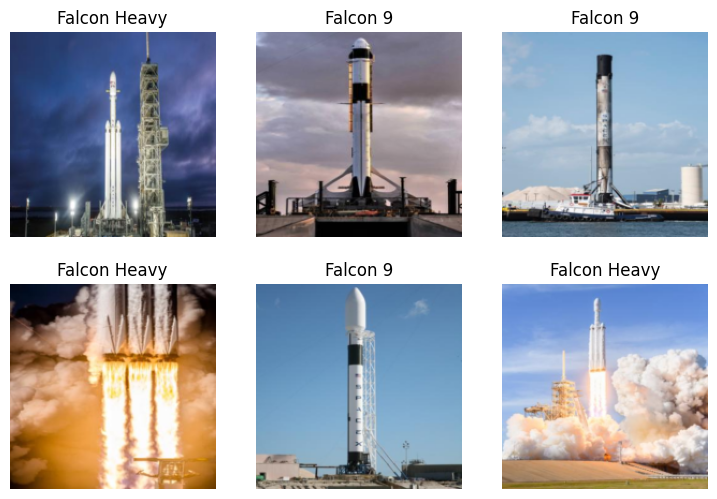

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [11]:
import ipywidgets as widgets

uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [12]:
img = PILImage.create(uploader.data[0])
which_rocket, _, probs = learn.predict(img)

print(f"This is a: {which_rocket}")
print(f"Probability: {probs[1]:.4f}")

IndexError: list index out of range

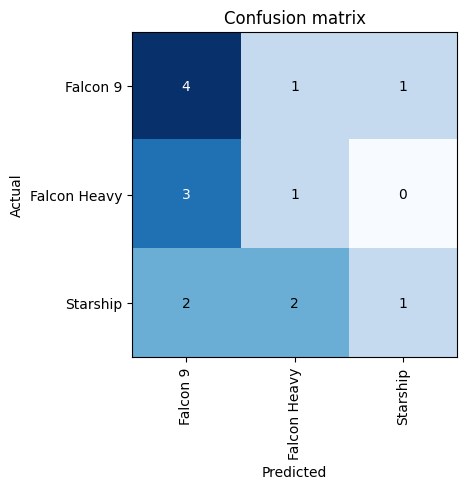

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

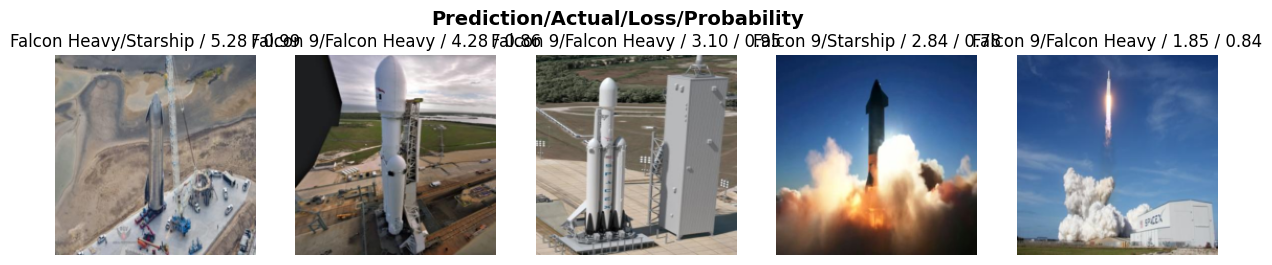

In [14]:
interp.plot_top_losses(5, nrows=1)

In [15]:
from fastai.vision.widgets import *

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [17]:
for idx in cleaner.delete():cleaner.fns[idx].unlink()
for idx, cat in cleaner.change():shutil.move(str(cleaner.fns[idx]), path/cat)